# PASCAL VOC : an `Image Segmentation` Problem 

Source: https://cs.stanford.edu/~roozbeh/pascal-context/

# Setup

In [1]:
import sagemaker

print(sagemaker.__version__)

sess = sagemaker.Session()
bucket = "aws-ml-demo-2020" 
prefix = "DEMO-ObjectSegmentation"

2.16.1


# Define the location of the Data Set

In [2]:
s3_train_data = 's3://{}/{}/train'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/validation'.format(bucket, prefix)
s3_train_annotation_data = 's3://{}/{}/train_annotation'.format(bucket, prefix)
s3_validation_annotation_data = 's3://{}/{}/validation_annotation'.format(bucket, prefix)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

print(s3_train_data)
print(s3_validation_data)
print(s3_train_annotation_data)
print(s3_validation_annotation_data)

s3://aws-ml-demo-2020/DEMO-ObjectSegmentation/train
s3://aws-ml-demo-2020/DEMO-ObjectSegmentation/validation
s3://aws-ml-demo-2020/DEMO-ObjectSegmentation/train_annotation
s3://aws-ml-demo-2020/DEMO-ObjectSegmentation/validation_annotation


# Get the name of the semantic-segmentation algorithm in our region

In [3]:
import boto3
from sagemaker import image_uris

region = boto3.Session().region_name    
container = image_uris.retrieve('semantic-segmentation', region)
print(container)

811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:1


# Training

Now we are ready to train our segmentation algorithm. To begin, let us create a `sageMaker.estimator.Estimator` object, specifying the image of the *Semantic Segmentation* algorithm container.

Here we'll also configure the base training job name (a timestamp will be appended when the job starts), and the infrastructure the training should run on (a GPU-accelerated `ml.p3.2xlarge` to keep our job nice and fast).

We'll use this Estimator later to actually start the training job in SageMaker.

In [4]:
from sagemaker import get_execution_role
 
role = get_execution_role()

seg = sagemaker.estimator.Estimator(container,
                                    role, 
                                    sagemaker_session = sess,
                                    instance_count = 1, 
                                    instance_type = 'ml.p3.2xlarge',
                                    output_path = s3_output_location)

The semantic segmentation algorithm at its core has two components.

- An encoder or backbone network,
- A decoder or algorithm network. 

The encoder or backbone network is typically a regular convolutional neural network that may or may not have had their layers pre-trained on an alternate task such as the [classification task of ImageNet images](http://www.image-net.org/). The Amazon SageMaker Semantic Segmentation algorithm comes with two choices of pre-trained or to be trained-from-scratch backbone networks ([ResNets](https://arxiv.org/abs/1512.03385) 50 or 101). 

The decoder is a network that picks up the outputs of one or many layers from the backbone and reconstructs the segmentation mask from it. Amazon SageMaker Semantic Segmentation algorithm comes with a choice of the [Fully-convolutional network (FCN)](https://arxiv.org/abs/1605.06211) or the [Pyramid scene parsing (PSP) network](https://arxiv.org/abs/1612.01105).

The algorithm also has ample options for hyperparameters that help configure the training job. The next step in our training, is to setup these networks and hyperparameters along with data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Semantic Segmentation [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `10` epochs. Based on our tests, train the model for `30` epochs with similar settings should give us 'reasonable' segmentation results on the Pascal VOC data. For the most part, we will stick to using the simplest of settings. For more information on the hyperparameters of this algorithm, refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/segmentation-hyperparameters.html).

In [7]:
# Setup hyperparameters 
seg.set_hyperparameters(
                        backbone='resnet-50',  # This is the encoder. Other option is resnet-101
                        algorithm='fcn',  # This is the decoder. Other options are 'psp' and 'deeplab'                             
                        use_pretrained_model='True',  # Use the pre-trained model.
                        crop_size=240,  # Size of image random crop.                             
                        num_classes=21,  # Pascal has 21 classes. This is a mandatory parameter.
                        epochs=10,  # Number of epochs to run.
                        learning_rate=0.0001,
                        optimizer='rmsprop',  # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                        lr_scheduler='poly',  # Other options include 'cosine' and 'step'.                           
                        mini_batch_size=16,  # Setup some mini batch size.
                        validation_mini_batch_size=16,
                        early_stopping=True,  # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                        early_stopping_patience=2,  # Tolerate these many epochs if the mIoU doens't increase.
                        early_stopping_min_epochs=10,  # No matter what, run these many number of epochs.                             
                        num_training_samples=1464,  # This is a mandatory parameter, 1464 in this case.
                       ) 

Next let us define the input data "channels" for training - as defined for this algorithm in the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html).

Each channel can be configured either with a simple `s3://...` string pointing to the data, or by a [sagemaker.inputs.TrainingInput](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) object which provides additional configuration options such as:

- How the data is distributed between nodes for multi-instance training jobs
- Whether the channel should use [Pipe Mode](https://aws.amazon.com/blogs/machine-learning/accelerate-model-training-using-faster-pipe-mode-on-amazon-sagemaker/), and other options

The channels are specified in a simple dictionary, specifying what data sources the training job should connect to and how.

In [8]:
train_data = sagemaker.TrainingInput(s3_train_data, 
                                     distribution='FullyReplicated', 
                                     content_type='image/jpeg', 
                                     s3_data_type='S3Prefix')

validation_data = sagemaker.TrainingInput(s3_validation_data, 
                                          distribution='FullyReplicated', 
                                          content_type='image/jpeg', 
                                          s3_data_type='S3Prefix')

train_annotation = sagemaker.TrainingInput(s3_train_annotation_data, 
                                           distribution='FullyReplicated', 
                                           content_type='image/png', 
                                           s3_data_type='S3Prefix')

validation_annotation = sagemaker.TrainingInput(s3_validation_annotation_data, 
                                                distribution='FullyReplicated', 
                                                content_type='image/png', 
                                                s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

We have our `Estimator` object with the hyperparameters and data channels for training defined, so the only remaining thing to do is actually train a model.

The following simple command will perform several steps:

- Firstly, the instances that we requested while creating the `Estimator` above are provisioned and the appropriate container image for the algorithm installed.
- Then, the data from our channels are downloaded into the instance.
- Once data and container are ready, the training job begins.
- Logs from the training will be pulled through to this notebook as it runs, including the loss on the training data (which is the pixel-wise cross-entropy loss as described in the algorithm docs) and the metrics on the validation data (pixel-wise label accuracy and mean intersection-over-union or mIoU)
- These logs and metrics will also be published to [Amazon CloudWatch](https://aws.amazon.com/cloudwatch/) - linked from the [Amazon SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/jobs) for your training job.
- When the training is complete, your model artifacts will be uploaded to Amazon S3 in the output location we specified earlier.
- As soon as the training job finishes (regardless of whether it succeeds or fails), the infrastructure is terminated - so we only pay for the GPU-accelerated training instance for the time that the job runs. Nice!

Once the job has finished a "Job complete" message will be printed below, and your trained model can then be found in the S3 location we set up for the estimator's `output_path`.

In [9]:
seg.fit(inputs=data_channels)

2020-11-25 10:48:54 Starting - Starting the training job...
2020-11-25 10:48:55 Starting - Launching requested ML instances.........
2020-11-25 10:50:29 Starting - Preparing the instances for training...
2020-11-25 10:51:15 Downloading - Downloading input data.........
2020-11-25 10:52:43 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[11/25/2020 10:53:03 INFO 140272169842496] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_hybrid': u'False', u'_augmentation_type': u'default', u'lr_scheduler

# Deployment

Once the training is done, we can deploy the trained model as an Amazon SageMaker hosted endpoint. This will allow us to make predictions (or inference) from the model.

Note that we don't have to host on the same number or type of instances that we used to train, and can choose any SageMaker-supported instance type. Training is compute-heavy job that may have different infrastructure requirements than inference/hosting. In our case we chose the GPU-accelerated `ml.p3.2xlarge` instance to train, but will host the model on a lower cost-per-hour `ml.c5.xlarge` type - because we'll only be serving occasional requests.

The endpoint deployment can be accomplished as follows:

In [10]:
seg_predictor = seg.deploy(initial_instance_count=1, instance_type='ml.c5.2xlarge')

-----------------!

# Inference

Now that the trained model is deployed to an endpoint, we can use this endpoint for inference.

To test it out, let us download an image from the web which the algorithm has so-far not seen. 

In [11]:
filename_raw = 'test-image1.jpeg'

The scale of the input image may affect the prediction results and latency, so we'll down-scale the raw image before sending it to our endpoint. You could experiment with different input resolutions (and aspect ratios) and see how the results change:

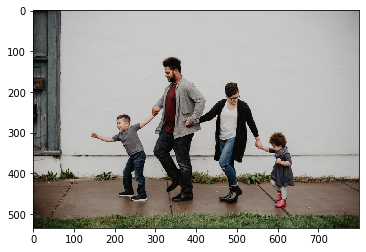

In [12]:
from matplotlib import pyplot as plt
import PIL
%matplotlib inline

filename = 'test_resized.jpg'
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

The endpoint accepts images in formats similar to the ones found images in the training dataset. The input `Content-Type` should be `image/jpeg`, and the output `Accept` type can be either:

- `image/png`, which produces an indexed-PNG segmentation mask as used in training: One predicted class ID per pixel... Or,
- `application/x-protobuf`, which produces a 3D matrix giving the *confidence of each class*, for each pixel.

In the SageMaker SDK, A `Predictor` has an associated **serializer** and **deserializer** which control how data gets translated to our API call, and loaded back into a Python result object.

There are pre-built [serializers](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html) and [deserializers](https://sagemaker.readthedocs.io/en/stable/api/inference/deserializers.html) offered by the SDK, and we're free to define custom ones so long as they offer the same API.


# Basic inference - class IDs PNG

In our first example, we'll request the simple PNG response and would like to map those into pixel arrays (assigned class for each pixel)... So we'll write a custom deserializer for that:

In [13]:
from PIL import Image
import numpy as np

class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""
    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


seg_predictor.deserializer = ImageDeserializer(accept="image/png")

For the input our data is already stored as a JPEG file, so we'll use the built-in `IdentitySerializer` and feed it the file bytes:

In [14]:
seg_predictor.serializer = sagemaker.serializers.IdentitySerializer('image/jpeg')

with open(filename, 'rb') as imfile:
    imbytes = imfile.read()

With that configured, calling our endpoint is now simple!

In [15]:
%%time

cls_mask = seg_predictor.predict(imbytes)

print(type(cls_mask))
print(cls_mask.shape)

<class 'numpy.ndarray'>
(534, 800)
CPU times: user 16.4 ms, sys: 459 µs, total: 16.9 ms
Wall time: 7.68 s


Let us display the segmentation mask.

Since the raw value of each pixel is a small number (the class ID), we'll apply a [colormap](https://matplotlib.org/3.3.2/tutorials/colors/colormaps.html) to make it a bit more human readable and not just a black square!

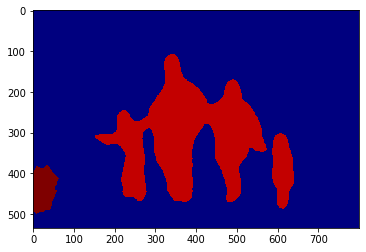

In [16]:
plt.imshow(cls_mask, cmap='jet')
plt.show()

# Delete the Endpoint

Deployed endpoints are backed by infrastructure (1x`ml.c5.xlarge` in our case, as we requested above) - so we should delete the endpoint when we're finished with it, to avoid incurring continued costs.

In [17]:
#seg_predictor.delete_endpoint()